In [4]:
from modules import data_loader
from modules import metrics
from modules import model
from modules import learning
from modules import spectrum_analysis
from modules import plotting
import scipy

Load data from files

In [2]:
data = data_loader.load_data("DPA_200MHz")

config = data["config"]
fs = config["input_signal_fs"]
bw_main_ch = config["bw_main_ch"]
bw_sub_ch = config["bw_sub_ch"]
n_sub_ch = config["n_sub_ch"]
nperseg = config["nperseg"]

x_in_tensor = data["train_input"]
x_out_tensor = data["train_output"]
y_in_tensor = data["val_input"]
y_out_tensor = data["val_output"]

In [3]:
# задание целевого сигнала как k*In

gain = metrics.calculate_gain_complex(x_in_tensor, x_out_tensor)
print(gain)

x_target = gain * x_in_tensor
y_target = gain * y_in_tensor


tensor(2.5208)


PA model

In [5]:
# задание параметров и расчёт модели усилителя

Ka=Ma=Kb=Mb=Kc=Mc=P=Q=10

pa_model = model.GeneralizedMemoryPolynomial(Ka, Ma, Kb, Mb, Kc, Mc, P, Q, model_type="pa_grad")

# проверка, существуют ли сохранённые коэффициенты для этого набора параметров, если нет, то они будут рассчитаны
if not pa_model.load_coefficients():
    pa_model.optimize_coefficients_grad(x_in_tensor, x_out_tensor, learning_rate=0.0001)

y_gmp_pa = pa_model.compute_output(y_in_tensor).detach()

nmse_pa = metrics.compute_nmse(y_gmp_pa, y_out_tensor)
print(f"NMSE PA (сравнение выхода модели и датасета PA): {nmse_pa}")

Coefficients loaded from model_params/pa_grad_gmp_model_Ka10_Ma10_Kb10_Mb10_Kc10_Mc10_P10_Q10.pt
NMSE PA (сравнение выхода модели и датасета PA): -26.093056201934814


d:\Учёба\проект\python\GMP DPD\modules\model.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


DLA DPD grad

In [6]:
Ka=Ma=Kb=Mb=Kc=Mc=P=Q=10

dpd_model_dla_grad = model.GeneralizedMemoryPolynomial(Ka, Ma, Kb, Mb, Kc, Mc, P, Q, model_type="dpd_dla_grad")

if not dpd_model_dla_grad.load_coefficients():
    learning.optimize_dla_grad(x_in_tensor, x_target, dpd_model_dla_grad, pa_model, learning_rate=0.0001)

y_dpd_dla_grad = dpd_model_dla_grad.compute_output(y_in_tensor).detach()
y_linearized_dla_grad = pa_model.compute_output(y_dpd_dla_grad).detach()

nmse_dla = metrics.compute_nmse(y_linearized_dla_grad, y_target)
print(f"NMSE на выходе усилителя (DLA DPD): {nmse_dla}")

Coefficients loaded from model_params/dpd_dla_grad_gmp_model_Ka10_Ma10_Kb10_Mb10_Kc10_Mc10_P10_Q10.pt
NMSE на выходе усилителя (DLA DPD): -34.594008922576904


ILA DPD grad

In [7]:
Ka=Ma=Kb=Mb=Kc=Mc=P=Q=10

dpd_model_ila_grad = model.GeneralizedMemoryPolynomial(Ka, Ma, Kb, Mb, Kc, Mc, P, Q, model_type="dpd_ila_grad")

if not dpd_model_ila_grad.load_coefficients():
    learning.optimize_ila_grad(dpd_model_ila_grad, x_in_tensor, x_out_tensor, gain, learning_rate=0.0001)

y_dpd_ila_grad = dpd_model_ila_grad.compute_output(y_in_tensor).detach()
y_linearized_ila_grad = pa_model.compute_output(y_dpd_ila_grad).detach()

nmse_ila = metrics.compute_nmse(y_linearized_ila_grad, y_target)
print(f"NMSE на выходе усилителя (ILA DPD): {nmse_ila}")


Coefficients loaded from model_params/dpd_ila_grad_gmp_model_Ka10_Ma10_Kb10_Mb10_Kc10_Mc10_P10_Q10.pt
NMSE на выходе усилителя (ILA DPD): -32.11216926574707


ILC DPD grad

In [9]:
u_k = learning.ilc_signal_grad(x_in_tensor, x_target, pa_model, max_iterations=200, learning_rate=0.1)

u_k_pa = pa_model.compute_output(u_k).detach()

Iteration 1/200, Loss: 0.05823964625597
Iteration 2/200, Loss: 0.09842687100172043
Iteration 3/200, Loss: 0.053740836679935455
Iteration 4/200, Loss: 0.03930288925766945
Iteration 5/200, Loss: 0.042917195707559586
Iteration 6/200, Loss: 0.03838625177741051
Iteration 7/200, Loss: 0.027650626376271248
Iteration 8/200, Loss: 0.02035762369632721
Iteration 9/200, Loss: 0.02121655084192753
Iteration 10/200, Loss: 0.023473098874092102
Iteration 11/200, Loss: 0.020803043618798256
Iteration 12/200, Loss: 0.015043811872601509
Iteration 13/200, Loss: 0.011158720590174198
Iteration 14/200, Loss: 0.011023025028407574
Iteration 15/200, Loss: 0.0122957993298769
Iteration 16/200, Loss: 0.011994762346148491
Iteration 17/200, Loss: 0.009768434800207615
Iteration 18/200, Loss: 0.007435160223394632
Iteration 19/200, Loss: 0.006455357652157545
Iteration 20/200, Loss: 0.0065668197348713875
Iteration 21/200, Loss: 0.0065924557857215405
Iteration 22/200, Loss: 0.005919382907450199
Iteration 23/200, Loss: 0.00

In [8]:
Ka=Ma=Kb=Mb=Kc=Mc=P=Q=10

dpd_model_ilc_grad = model.GeneralizedMemoryPolynomial(Ka, Ma, Kb, Mb, Kc, Mc, P, Q, model_type="dpd_ilc_grad")

# проверка, существуют ли сохранённые коэффициенты для этого набора параметров, если нет, то они будут рассчитаны
if not dpd_model_ilc_grad.load_coefficients():
    dpd_model_ilc_grad.optimize_coefficients_grad(x_in_tensor, u_k, learning_rate=0.0001)


y_dpd_ilc_grad = dpd_model_ilc_grad.compute_output(y_in_tensor).detach()
y_linearized_ilc_grad = pa_model.compute_output(y_dpd_ilc_grad).detach()

nmse_ilc = metrics.compute_nmse(y_linearized_ilc_grad, y_target)
print(f"NMSE на выходе усилителя (ILC DPD): {nmse_ilc}")

Coefficients loaded from model_params/dpd_ilc_grad_gmp_model_Ka10_Ma10_Kb10_Mb10_Kc10_Mc10_P10_Q10.pt
NMSE на выходе усилителя (ILC DPD): -34.22328472137451


In [26]:
nmse_after_pa = metrics.compute_nmse(y_gmp_pa, y_target)
nmse_uk_pa = metrics.compute_nmse(u_k_pa, x_target)

print(f"NMSE на выходе усилителя (без DPD): {nmse_after_pa:.2f} db")

print(f"NMSE на выходе усилителя (DLA DPD): {nmse_dla:.2f} db")

print(f"NMSE на выходе усилителя (ILA DPD): {nmse_ila:.2f} db")

print(f"NMSE на выходе усилителя (ILC):     {nmse_uk_pa:.2f} db")

print(f"NMSE на выходе усилителя (ILC DPD): {nmse_ilc:.2f} db")

NameError: name 'u_k_pa' is not defined

In [11]:
y_in_acpr = spectrum_analysis.calculate_acpr(y_in_tensor, fs, bw_main_ch, bw_sub_ch, n_sub_ch, nperseg)
y_out_acpr = spectrum_analysis.calculate_acpr(y_out_tensor, fs, bw_main_ch, bw_sub_ch, n_sub_ch, nperseg)
y_gmp_pa_acpr = spectrum_analysis.calculate_acpr(y_gmp_pa, fs, bw_main_ch, bw_sub_ch, n_sub_ch, nperseg)
y_target_acpr = spectrum_analysis.calculate_acpr(y_target, fs, bw_main_ch, bw_sub_ch, n_sub_ch, nperseg)

y_linearized_dla_grad_acpr = spectrum_analysis.calculate_acpr(y_linearized_dla_grad, fs, bw_main_ch, bw_sub_ch, n_sub_ch, nperseg)
y_linearized_ila_grad_acpr = spectrum_analysis.calculate_acpr(y_linearized_ila_grad, fs, bw_main_ch, bw_sub_ch, n_sub_ch, nperseg)
y_linearized_ilc_grad_acpr = spectrum_analysis.calculate_acpr(y_linearized_ilc_grad, fs, bw_main_ch, bw_sub_ch, n_sub_ch, nperseg)

print(f"y_in_acpr: {y_in_acpr}")
print(f"y_out_acpr: {y_out_acpr}")
print(f"y_gmp_pa_acpr: {y_gmp_pa_acpr}")
print(f"y_target_acpr: {y_target_acpr}")

print(f"linearized_dla_grad_acpr: {y_linearized_dla_grad_acpr}")
print(f"linearized_ila_grad_acpr: {y_linearized_ila_grad_acpr}")
print(f"linearized_ilc_grad_acpr: {y_linearized_ilc_grad_acpr}")


y_in_acpr: -55.24476343867217
y_out_acpr: -35.15757339044456
y_gmp_pa_acpr: -35.21809983849926
y_target_acpr: -39.18316651089891
linearized_dla_grad_acpr: -39.1946103001948
linearized_ila_grad_acpr: -39.36219556848155
linearized_ilc_grad_acpr: -39.19059877986133


In [12]:
u_k_acpr = spectrum_analysis.calculate_acpr(u_k, fs, bw_main_ch, bw_sub_ch, n_sub_ch, nperseg)
u_k_pa_acpr = spectrum_analysis.calculate_acpr(u_k_pa, fs, bw_main_ch, bw_sub_ch, n_sub_ch, nperseg)
_, spectrum_u_k = spectrum_analysis.power_spectrum(u_k, fs, nperseg)
_, spectrum_u_k_pa = spectrum_analysis.power_spectrum(u_k_pa, fs, nperseg)
print(f"u_k_acpr: {u_k_acpr}")
print(f"u_k_pa_acpr: {u_k_pa_acpr}")

NameError: name 'u_k' is not defined

Spectrum

In [13]:
freqs, spectrum_y_in = spectrum_analysis.power_spectrum(y_in_tensor, fs, nperseg)
_, spectrum_y_out = spectrum_analysis.power_spectrum(y_out_tensor, fs, nperseg)
_, spectrum_y_gmp_pa = spectrum_analysis.power_spectrum(y_gmp_pa, fs, nperseg)
_, spectrum_y_target = spectrum_analysis.power_spectrum(y_target, fs, nperseg)

_, spectrum_y_dpd_dla_grad = spectrum_analysis.power_spectrum(y_dpd_dla_grad, fs, nperseg)
_, spectrum_y_dpd_ila_grad = spectrum_analysis.power_spectrum(y_dpd_ila_grad, fs, nperseg)
_, spectrum_y_dpd_ilc_grad = spectrum_analysis.power_spectrum(y_dpd_ilc_grad, fs, nperseg)

_, spectrum_y_linearized_dla_grad = spectrum_analysis.power_spectrum(y_linearized_dla_grad, fs, nperseg)
_, spectrum_y_linearized_ila_grad = spectrum_analysis.power_spectrum(y_linearized_ila_grad, fs, nperseg)
_, spectrum_y_linearized_ilc_grad = spectrum_analysis.power_spectrum(y_linearized_ilc_grad, fs, nperseg)

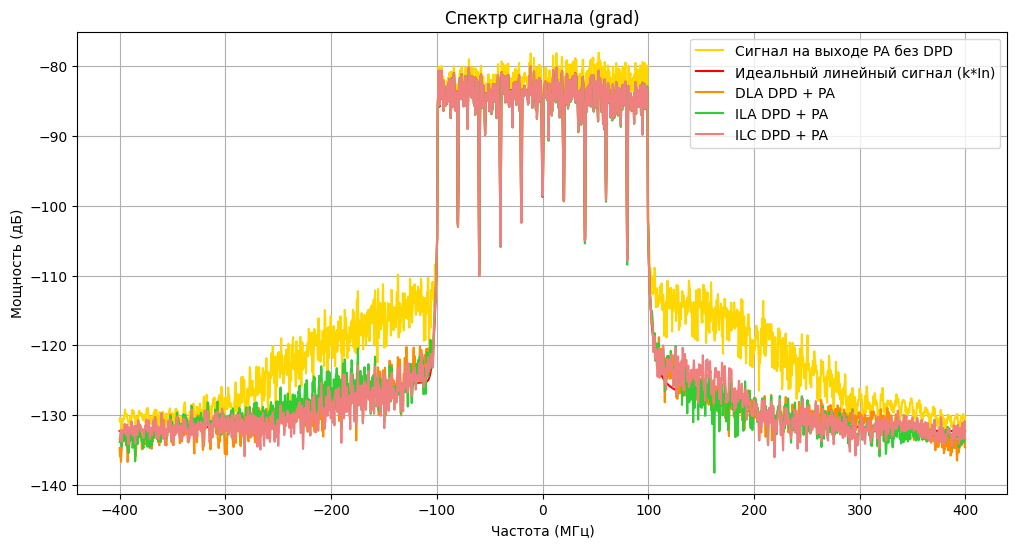

In [14]:
# построение спектра

spectra = [
    (spectrum_y_gmp_pa, 'gold', 'Сигнал на выходе PA без DPD'),
    (spectrum_y_target, 'red', 'Идеальный линейный сигнал (k*In)'),
    (spectrum_y_linearized_dla_grad, 'darkorange', 'DLA DPD + PA'),
    (spectrum_y_linearized_ila_grad, 'limegreen', 'ILA DPD + PA'),
    (spectrum_y_linearized_ilc_grad, 'lightcoral', 'ILC DPD + PA'),
]

plotting.plot_signal_spectra(
    freqs=freqs,
    spectra=spectra,
    title='Спектр сигнала (grad)',
    xlabel='Частота (МГц)',
    ylabel='Мощность (дБ)'
)


AM/AM & AM/PM

In [18]:
y_in_am_am, y_out_am_am = metrics.calculate_am_am(y_in_tensor, y_out_tensor)
y_in_am_pm, y_in_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_out_tensor)

_, y_pa_am_am = metrics.calculate_am_am(y_in_tensor, y_gmp_pa)
_, y_pa_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_gmp_pa)

_, y_target_am_am = metrics.calculate_am_am(y_in_tensor, y_target)
_, y_target_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_target)

# x_in_am_am, u_k_am_am = metrics.calculate_am_am(x_in_tensor, u_k)
# x_in_am_pm, u_k_phase_am_pm = metrics.calculate_am_pm(x_in_tensor, u_k)

# _, u_k_pa_am_am = metrics.calculate_am_am(x_in_tensor, u_k_pa)
# _, u_k_pa_phase_am_pm = metrics.calculate_am_pm(x_in_tensor, u_k_pa)

# dpd
_, y_dpd_dla_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_dpd_dla_grad)
_, y_dpd_dla_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_dpd_dla_grad)

_, y_dpd_ila_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_dpd_ila_grad)
_, y_dpd_ila_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_dpd_ila_grad)

_, y_dpd_ilc_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_dpd_ilc_grad)
_, y_dpd_ilc_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_dpd_ilc_grad)

#linearized
_, y_linearized_dla_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_linearized_dla_grad)
_, y_linearized_dla_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_linearized_dla_grad)

_, y_linearized_ila_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_linearized_ila_grad)
_, y_linearized_ila_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_linearized_ila_grad)

_, y_linearized_ilc_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_linearized_ilc_grad)
_, y_linearized_ilc_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_linearized_ilc_grad)


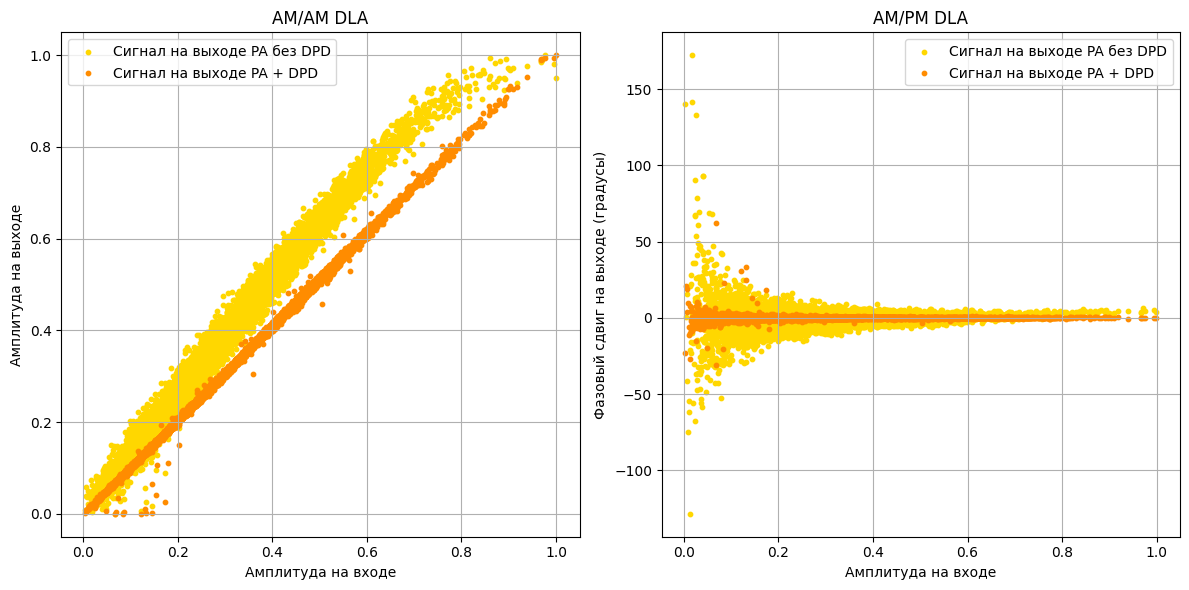

In [25]:
#DLA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Сигнал на выходе PA без DPD'),
    # (y_in_am_am, y_dpd_dla_grad_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_linearized_dla_grad_am_am, 'darkorange', 'Сигнал на выходе PA + DPD'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Сигнал на выходе PA без DPD'),
    (y_in_am_pm, y_linearized_dla_grad_phase_am_pm, 'darkorange', 'Сигнал на выходе PA + DPD'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM DLA", "AM/PM DLA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)



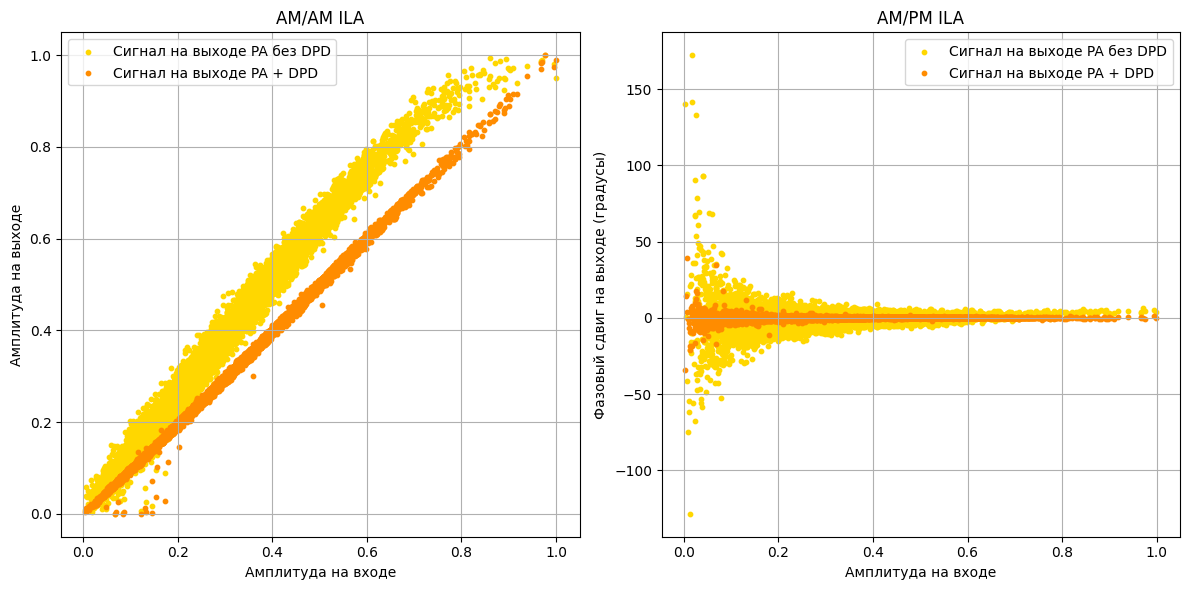

In [21]:
#ILA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Сигнал на выходе PA без DPD'),
    # (y_in_am_am, y_dpd_ila_grad_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_linearized_ila_grad_am_am, 'darkorange', 'Сигнал на выходе PA + DPD'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Сигнал на выходе PA без DPD'),
    (y_in_am_pm, y_linearized_ila_grad_phase_am_pm, 'darkorange', 'Сигнал на выходе PA + DPD'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILA", "AM/PM ILA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


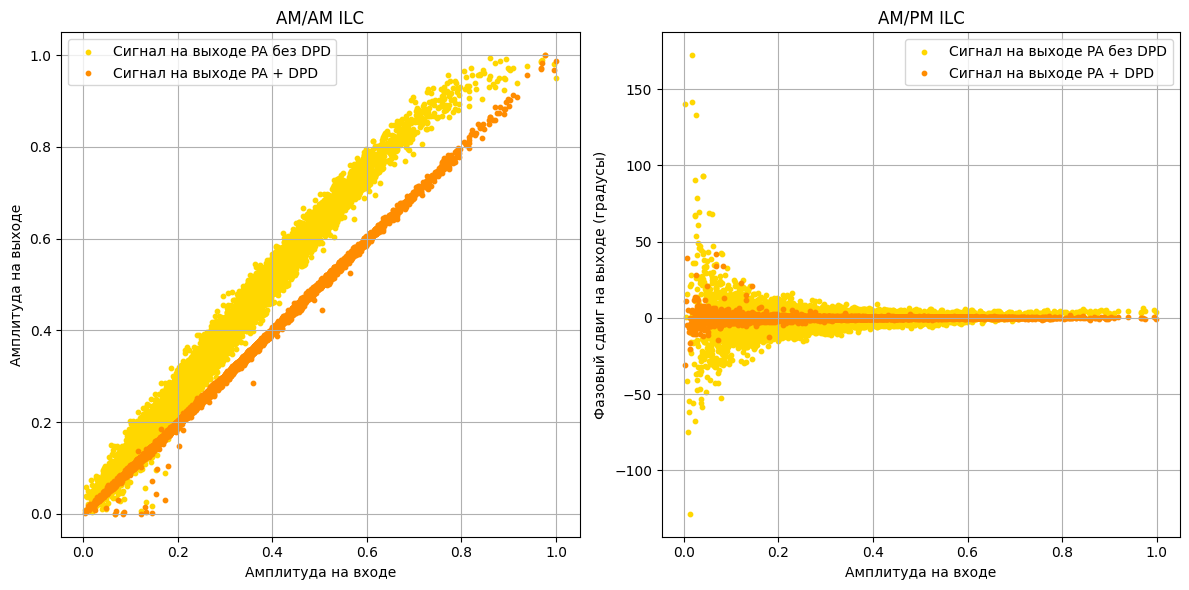

In [22]:
#ILC

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Сигнал на выходе PA без DPD'),
    # (y_in_am_am, y_dpd_ilc_grad_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_linearized_ilc_grad_am_am, 'darkorange', 'Сигнал на выходе PA + DPD'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Сигнал на выходе PA без DPD'),
    (y_in_am_pm, y_linearized_ilc_grad_phase_am_pm, 'darkorange', 'Сигнал на выходе PA + DPD'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILC", "AM/PM ILC"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


In [23]:
total_parameters = Ma * Ka + Mb * Kb * P + Mc * Kc * Q

print(f"Total parameters in dpd gmp model: {total_parameters}")

Total parameters in dpd gmp model: 2100


In [ ]:
# # Save .mat files

# scipy.io.savemat("mat_files/y_in_tensor.mat", {'y_in_tensor':y_in_tensor.numpy()})
# scipy.io.savemat("mat_files/y_out_tensor.mat", {'y_out_tensor':y_out_tensor.numpy()})
# scipy.io.savemat("mat_files/y_target.mat", {'y_target':y_target.numpy()})
# scipy.io.savemat("mat_files/u_k_pa.mat", {'u_k_pa':u_k_pa.numpy()})
# scipy.io.savemat("mat_files/y_linearized_dla_grad.mat", {'y_linearized_dla_grad':y_linearized_dla_grad.numpy()})
# scipy.io.savemat("mat_files/y_linearized_ila_grad.mat", {'y_linearized_ila_grad':y_linearized_ila_grad.numpy()})
# scipy.io.savemat("mat_files/y_linearized_ilc_grad.mat", {'y_linearized_ilc_grad':y_linearized_ilc_grad.numpy()})